# Complete Pipeline: Clustering, Classification and Optimization

This notebook contains the complete and self-contained pipeline for analyzing student profiles from the MAMBA research group. The process is as follows:

1. **Data Loading and Preparation:** The dataset is loaded and the variables to be used are defined.
2. **Data Splitting:** Data is separated into training and test sets.
3. **Preprocessing and Clustering:** A pipeline is applied that normalizes numerical data, encodes categorical data, and then uses a GMM model to assign a cluster (profile) to each student in the training and test sets.
4. **Resampling (Oversampling):** Classes (clusters) are balanced in the training set so that each profile has 100 samples, avoiding biases in the model.
5. **Model Definition and Hyperparameter Grid:** The 6 models to be compared and their respective configurations for optimization with `GridSearchCV` are defined.
6. **Training and Optimization:** Each model is trained with its default configuration and then the best possible configuration is searched through `GridSearchCV`. All metrics are saved.
7. **Comparative Visualization:** A bar chart is generated to compare the F1-Score of the 12 models (6 baseline vs. 6 optimized).
8. **Feature Importance Analysis:** The best overall model is identified and the variables that most influenced its predictions are visualized.

## Import Libraries

In [31]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.utils import resample

# Visualization and warnings setup
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)
sns.set_style('whitegrid')

## 1. Data Loading and Preparation

In [32]:
print('--- 1. Data Loading and Preparation ---')
file_path = ''
df = pd.read_excel('./RespuestasSemillero.xlsx')

features = ['Q5', 'Q7', 'Q8', 'Q9', 'Q10', 'Q23', 'Q25', 'Q30', 'Q31']
X = df[features]
y_placeholder = df['Q6']  # Placeholder for initial split

--- 1. Data Loading and Preparation ---


## 2. Data Splitting

In [33]:
print('--- 2. Data Splitting ---')
X_train, X_test, _, _ = train_test_split(X, y_placeholder, test_size=0.4, random_state=42)
print(f'Training set size: {X_train.shape[0]} rows')
print(f'Test set size: {X_test.shape[0]} rows')

--- 2. Data Splitting ---
Training set size: 48 rows
Test set size: 33 rows


## 3. Preprocessing and Clustering

In [34]:
print('--- 3. Preprocessing and Clustering ---')
categorical_features = X_train.select_dtypes(include=['object', 'category']).columns
numerical_features = X_train.select_dtypes(include=np.number).columns

preprocessor = ColumnTransformer(transformers=[
    ('num', MinMaxScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', drop='first', sparse_output=False), categorical_features)])

clustering_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clusterer', GaussianMixture(n_components=3, random_state=42))])

# Train the clustering pipeline ONLY with training data
clustering_pipeline.fit(X_train)

# Generate labels (profiles) for both sets
y_train = clustering_pipeline.predict(X_train)
y_test = clustering_pipeline.predict(X_test)

print('Cluster distribution in training set:')
print(pd.Series(y_train).value_counts())
print('\nCluster distribution in test set:')
print(pd.Series(y_test).value_counts())

--- 3. Preprocessing and Clustering ---
Cluster distribution in training set:
2    24
1    15
0     9
Name: count, dtype: int64

Cluster distribution in test set:
2    18
0    12
1     3
Name: count, dtype: int64


## 4. Resampling (Oversampling) of Training Set

In [35]:
print('--- 4. Resampling (Oversampling) of Training Set ---')
# Process training data to combine with labels
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

train_processed_df = pd.DataFrame(X_train_processed)
train_processed_df['cluster'] = y_train

resampled_dfs = []
for label in train_processed_df['cluster'].unique():
    cluster_df = train_processed_df[train_processed_df['cluster'] == label]
    resampled_cluster = resample(cluster_df, replace=True, n_samples=1000, random_state=42)
    resampled_dfs.append(resampled_cluster)

resampled_train_df = pd.concat(resampled_dfs)
X_train_resampled = resampled_train_df.drop('cluster', axis=1).values
y_train_resampled = resampled_train_df['cluster'].values

print('New cluster distribution in resampled training set:')
print(pd.Series(y_train_resampled).value_counts())

--- 4. Resampling (Oversampling) of Training Set ---
New cluster distribution in resampled training set:
1    1000
2    1000
0    1000
Name: count, dtype: int64


## 5. Model Definition and Hyperparameter Grid

In [36]:
print('--- 5. Model Definition and Hyperparameter Grid ---')
models = {
    'LogReg': LogisticRegression(random_state=42, max_iter=2000),
    'RandForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss'),
    'SVC': SVC(random_state=42, probability=True),
    'NaiveBayes': GaussianNB(),
    'MLP': MLPClassifier(random_state=42, max_iter=1500)
}

param_grids = {
    'LogReg': {'C': [0.1, 1, 10], 'solver': ['liblinear', 'saga']},
    'RandForest': {'n_estimators': [100, 150], 'max_depth': [None, 10], 'min_samples_split': [2, 5]},
    'XGBoost': {'n_estimators': [100, 150], 'learning_rate': [0.05, 0.1], 'max_depth': [3, 5]},
    'SVC': {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']},
    'NaiveBayes': {'var_smoothing': np.logspace(0,-9, num=10)},
    'MLP': {'hidden_layer_sizes': [(50,), (100,)], 'alpha': [0.0001, 0.001]}
}
print('Models and parameters defined.')

--- 5. Model Definition and Hyperparameter Grid ---
Models and parameters defined.


## 6. Model Training and Optimization

In [37]:
print('--- 6. Model Training and Optimization ---')
print('This process may take several minutes...')
results = []
best_models_optimized = {}

for name in models.keys():
    print(f'Processing {name}...')
    # Baseline Model
    model_base = models[name]
    model_base.fit(X_train_resampled, y_train_resampled)
    y_pred_base = model_base.predict(X_test_processed)
    f1_base = f1_score(y_test, y_pred_base, average='weighted')
    results.append({'Model': name, 'Type': 'Default', 'F1-Score': f1_base})

    # Optimized Model
    grid_search = GridSearchCV(estimator=models[name], param_grid=param_grids[name], cv=10, n_jobs=-1, scoring='f1_weighted')
    grid_search.fit(X_train_resampled, y_train_resampled)
    best_model = grid_search.best_estimator_
    best_models_optimized[name] = best_model
    y_pred_opt = best_model.predict(X_test_processed)
    f1_opt = f1_score(y_test, y_pred_opt, average='weighted')
    results.append({'Model': name, 'Type': 'Optimized', 'F1-Score': f1_opt})

results_df = pd.DataFrame(results)
print('\n--- Process completed ---')
results_df

--- 6. Model Training and Optimization ---
This process may take several minutes...
Processing LogReg...
Processing RandForest...
Processing XGBoost...
Processing SVC...
Processing NaiveBayes...
Processing MLP...

--- Process completed ---


,Model,Type,F1-Score
0,LogReg,Default,0.910009
1,LogReg,Optimized,0.910009
2,RandForest,Default,0.910009
3,RandForest,Optimized,0.910009
4,XGBoost,Default,0.910009
5,XGBoost,Optimized,0.910009
6,SVC,Default,0.910009
7,SVC,Optimized,0.910009
8,NaiveBayes,Default,0.939942
9,NaiveBayes,Optimized,0.910009


## 7. Comparative Visualization

--- 7. Comparative Visualization ---


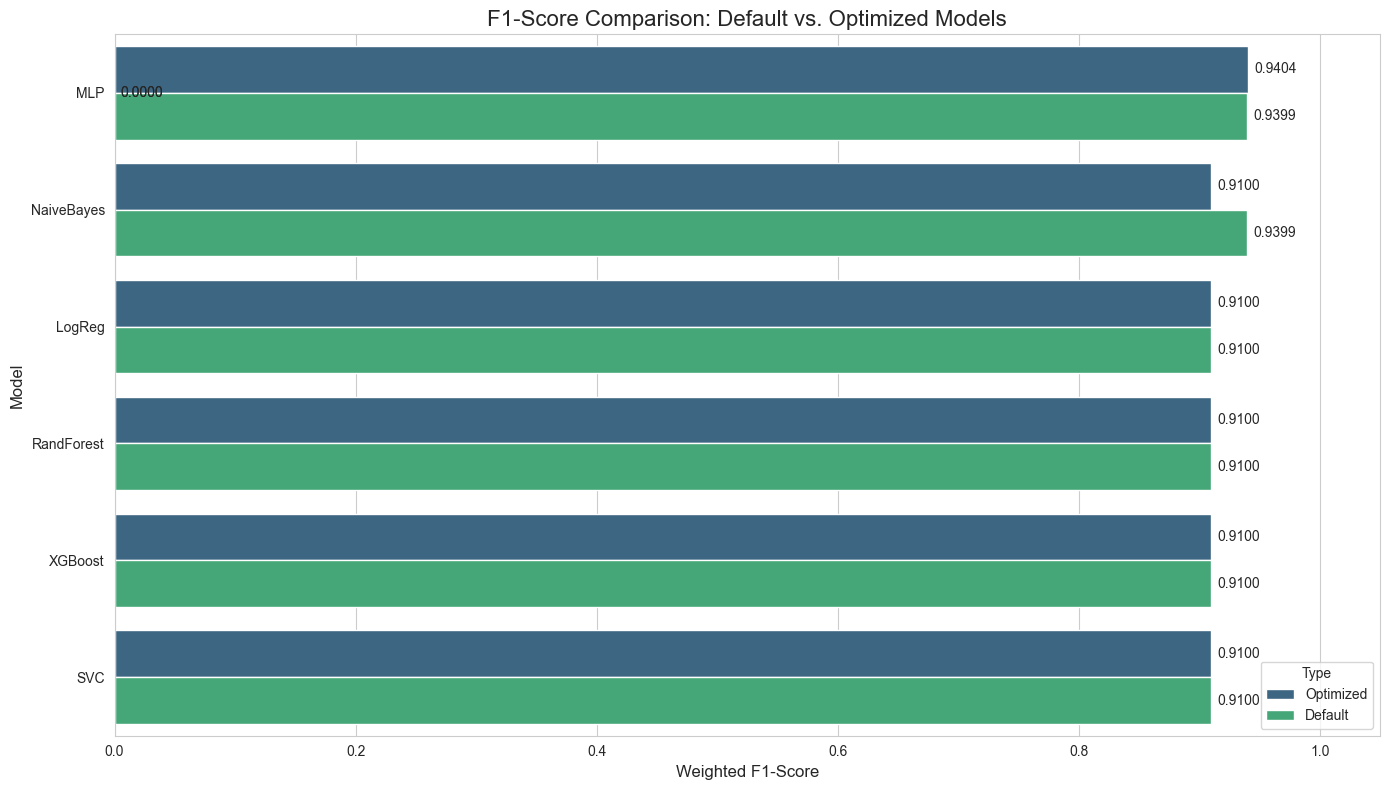

In [38]:
print('--- 7. Comparative Visualization ---')
plt.figure(figsize=(14, 8))
ax = sns.barplot(x='F1-Score', y='Model', hue='Type', data=results_df.sort_values('F1-Score', ascending=False), palette='viridis')
plt.title('F1-Score Comparison: Default vs. Optimized Models', fontsize=16)
plt.xlabel('Weighted F1-Score', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.legend(title='Type')
plt.xlim(0, 1.05)

for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.005, p.get_y() + p.get_height() / 2, f'{width:.4f}', va='center')

plt.tight_layout()
plt.show()

## 8. Feature Importance Analysis

In [39]:
print('--- 8. Feature Importance Analysis ---')
best_overall_model_info = results_df.loc[results_df['F1-Score'].idxmax()]
best_model_name = best_overall_model_info['Model']
best_model_instance = best_models_optimized[best_model_name]

print(f'The best overall model is: {best_model_name} (Optimized)')

ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = list(numerical_features) + list(ohe_feature_names)

importances = np.zeros(len(all_feature_names))
if hasattr(best_model_instance, 'feature_importances_'):
    importances = best_model_instance.feature_importances_
elif hasattr(best_model_instance, 'coef_'):
    if best_model_instance.coef_.ndim > 1:
        importances = np.mean(np.abs(best_model_instance.coef_), axis=0)
    else:
        importances = np.abs(best_model_instance.coef_[0])

feature_importance_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

if not feature_importance_df.empty and feature_importance_df['Importance'].sum() > 0:
    plt.figure(figsize=(12, 10))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='rocket')
    plt.title(f'Top 15 Most Important Features - {best_model_name} Optimized', fontsize=16)
    plt.xlabel('Importance', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.show()
else:
    print(f'Could not generate feature importance plot for model {best_model_name}.')

--- 8. Feature Importance Analysis ---
The best overall model is: MLP (Optimized)
Could not generate feature importance plot for model MLP.


## Alternative Approach: XGBoost Feature Importance

Training XGBoost model...
Extracting and visualizing feature importance...

--- Top 10 Most Important Features ---
                                       Feature  Importance
13                    Q31_Frontend development    0.601241
6                       Q10_Learn meaningfully    0.387651
12  Q31_Data analysis through machine learning    0.004288
3                                           Q9    0.003790
4                                          Q23    0.001973
1                                           Q7    0.000535
2                                           Q8    0.000522
0                                           Q5    0.000000
7        Q10_Solve problems of social interest    0.000000
5                                          Q25    0.000000


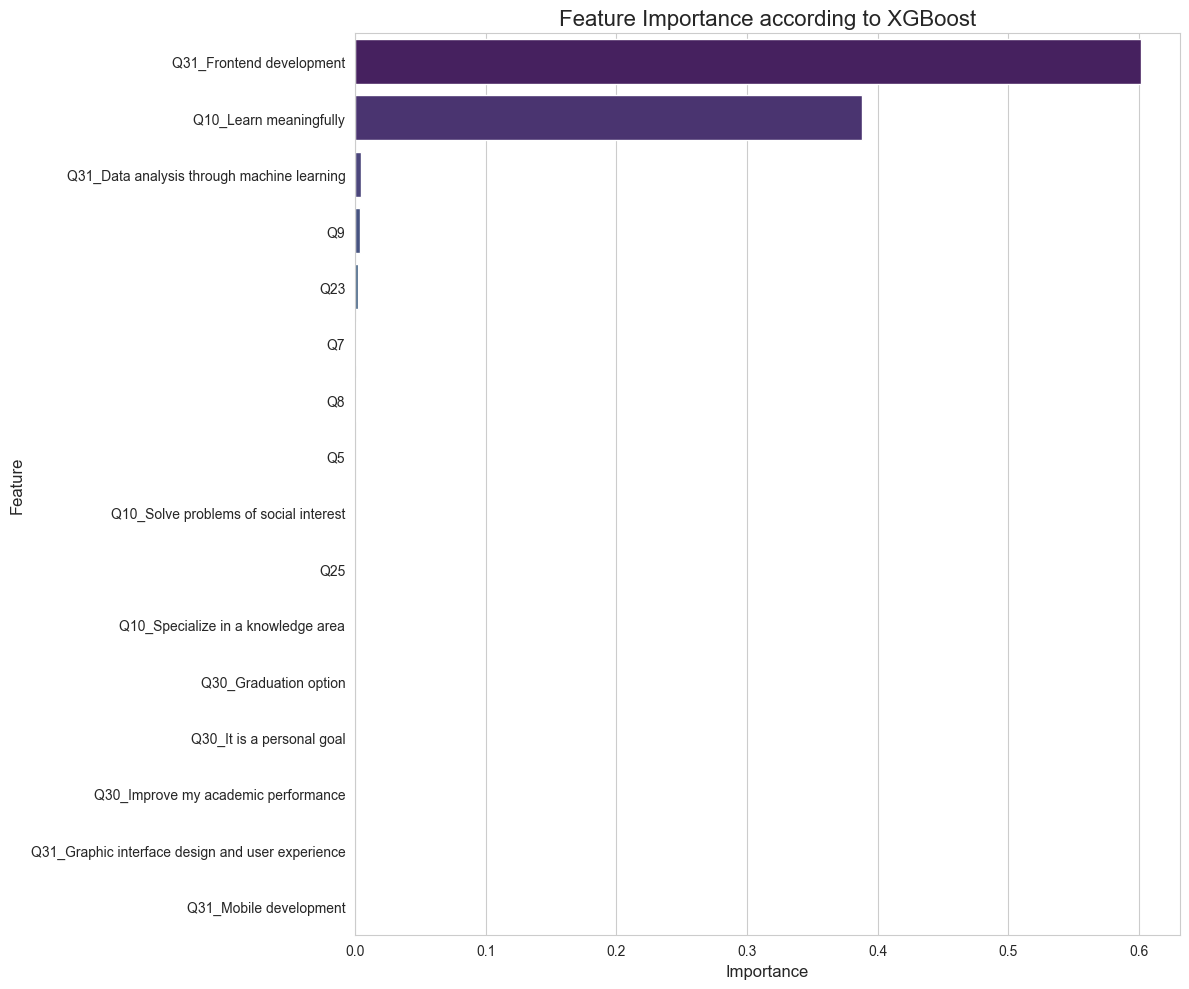

In [40]:
# --- Alternative: XGBoost Model Training ---
print("Training XGBoost model...")
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train_processed, y_train)

# --- Feature Importance Extraction and Visualization ---
print("Extracting and visualizing feature importance...")
importances = xgb_model.feature_importances_

ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = list(numerical_features) + list(ohe_feature_names)

feature_importance_df = pd.DataFrame({
    'Feature': all_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n--- Top 10 Most Important Features ---")
print(feature_importance_df.head(10))

plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='viridis')
plt.title('Feature Importance according to XGBoost', fontsize=16)
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
plt.show()